Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [14]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [15]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [16]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r"D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r'D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [17]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [18]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [19]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [20]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
def load_validation_dataset(data_dir, seed=123):
    """
    Load validation image dataset from the given directory.

    Args:
        data_dir (str): Path to the dataset directory.
        seed (int): Seed for reproducibility.

    Returns:
        tf.data.Dataset: Loaded validation image dataset.
    """
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

# Load validation dataset
validation_ds = load_validation_dataset(data_dir_train)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [21]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
def get_dataset_class_names(dataset):
    """
    Get the class names from the given dataset.

    Args:
        dataset (tf.data.Dataset): Input dataset.

    Returns:
        list: List of class names.
    """
    return dataset.class_names

# Get class names from the training dataset
class_names = get_dataset_class_names(train_ds)

# Calculate the number of classes
num_classes = len(class_names)

# Print the class names
print("Name of Output Image Classifiers:", class_names)


Name of Output Image Classifiers: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

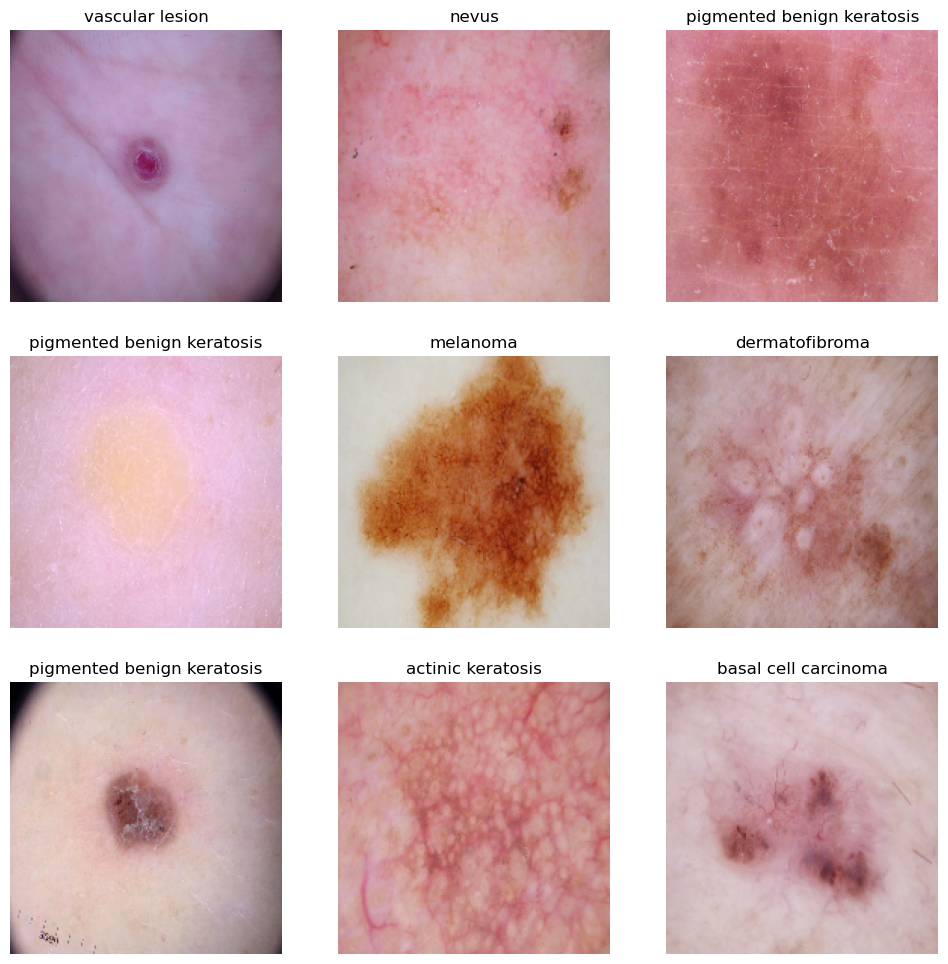

In [22]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

def display_images(dataset, class_names, num_images=9):
    """
    Display a grid of images from the given dataset.

    Args:
        dataset (tf.data.Dataset): Input dataset.
        class_names (list): List of class names.
        num_images (int): Number of images to display.

    Returns:
        None
    """
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint16"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

# Display images from the training dataset
display_images(train_ds, class_names)
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess_dataset(dataset, cache=True, shuffle_buffer_size=1000, prefetch_buffer_size=AUTOTUNE):
    """
    Preprocess the given dataset.

    Args:
        dataset (tf.data.Dataset): Input dataset.
        cache (bool): Whether to cache the dataset.
        shuffle_buffer_size (int): Size of the buffer for shuffling (if applicable).
        prefetch_buffer_size (int): Number of elements to prefetch (if applicable).

    Returns:
        tf.data.Dataset: Processed dataset.
    """
    if cache:
        dataset = dataset.cache()

    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)

    dataset = dataset.prefetch(buffer_size=prefetch_buffer_size)

    return dataset

# Preprocess the training dataset
train_ds = preprocess_dataset(train_ds)

# Preprocess the test dataset
val_ds = preprocess_dataset(validation_ds, cache=False)  # Avoid caching for test dataset



### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [24]:
### Your code goes here
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers.experimental import preprocessing

# Define input shape
input_shape = (180, 180, 3)

# Create a Sequential model
model = Sequential()

# Preprocessing layer
model.add(preprocessing.Rescaling(1./255, input_shape=input_shape))

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(9, activation='softmax'))



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Todo, choose an appropirate optimiser and loss function
model.compile(
    optimizer=Adam(),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [26]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

### Train the model

In [27]:
epochs=20
history = model.fit(
  train_ds,
    batch_size=32,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 131s 2s/step - loss: 2.0684 - accuracy: 0.1908 - val_loss: 2.0838 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 87s 2s/step - loss: 2.0226 - accuracy: 0.2070 - val_loss: 2.0257 - val_accuracy: 0.2237
Epoch 3/20
56/56 [==============================] - 81s 1s/step - loss: 1.9769 - accuracy: 0.2360 - val_loss: 1.9785 - val_accuracy: 0.2304
Epoch 4/20
56/56 [==============================] - 81s 1s/step - loss: 1.8861 - accuracy: 0.2729 - val_loss: 1.8974 - val_accuracy: 0.2528
Epoch 5/20
56/56 [==============================] - 82s 1s/step - loss: 1.7553 - accuracy: 0.3359 - val_loss: 1.6538 - val_accuracy: 0.3691
Epoch 6/20
56/56 [==============================] - 85s 2s/step - loss: 1.6378 - accuracy: 0.3912 - val_loss: 1.8234 - val_accuracy: 0.2998
Epoch 7/20
56/56 [==============================] - 91s 2s/step - loss: 1.6213 - accuracy: 0.4174 - val_loss: 1.5756 - val_accuracy: 0.4586
Epoch 8/20
56/56 

### Visualizing training results

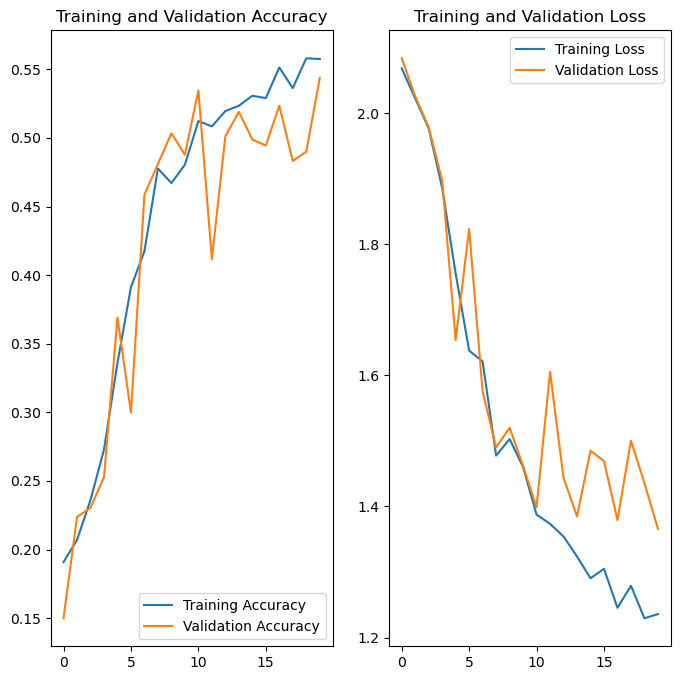

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. The accuracy for both training and validation seems to continuosly increasing, which is a good for the model.
2. Accuracy percentage is not encouraging which is not a good sign shows underfitting.
3. we can see the jumps in validation data, while the training is bit smooth.

In [29]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

def create_data_augmentation():
    """
    Create a Sequential model for data augmentation.

    Returns:
        tf.keras.Sequential: Data augmentation model.
    """
    data_augmentation = keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomContrast(0.1),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomZoom(0.2)
    ])

    return data_augmentation

# Create the data augmentation model
data_augmentation_model = create_data_augmentation()


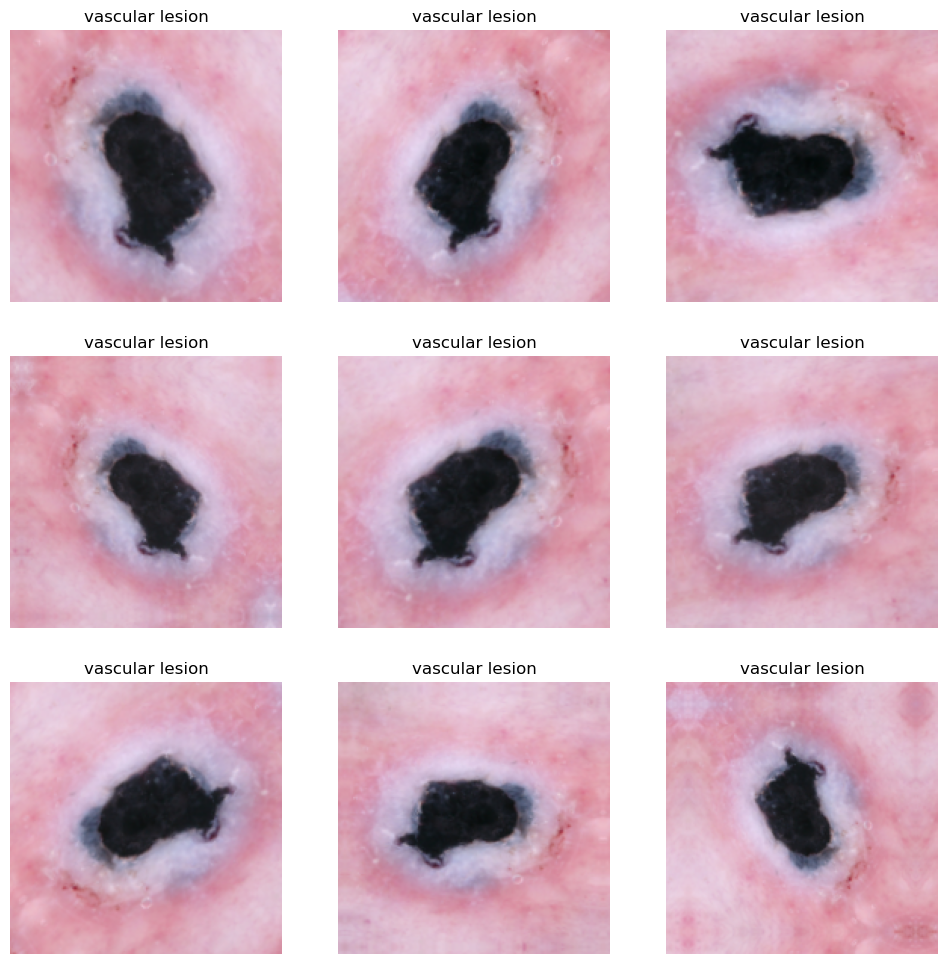

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

def visualize_augmentation(data_augmentation_model, dataset, class_names, num_images=9):
    """
    Visualize the augmentation strategy for one instance of a training image.

    Args:
        data_augmentation_model (tf.keras.Sequential): Data augmentation model.
        dataset (tf.data.Dataset): Input dataset.
        class_names (list): List of class names.
        num_images (int): Number of images to display.

    Returns:
        None
    """
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            augmented_image = data_augmentation_model(images, training=True)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_image[0].numpy().astype("uint16"))
            plt.axis("off")
            plt.title(class_names[labels[0]])

# Visualize data augmentation for one instance
visualize_augmentation(data_augmentation_model, train_ds, class_names)
plt.show()


### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
# input shape = (img_rows, img_cols, channels)
model = Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# adding augmented images
model.add(data_augmentation_model)

# first layer
model.add(Conv2D(32, kernel_size=(3,3),padding="same",activation='relu',input_shape=(180, 180, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# second layer
model.add(Conv2D(64, kernel_size=(3, 3),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# third layer
model.add(Conv2D(64, kernel_size=(3, 3),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# fourth layer
model.add(Conv2D(128, kernel_size=(5, 5),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# fifth layer
model.add(Conv2D(128, kernel_size=(5, 5),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# sixth layer
model.add(Conv2D(256, kernel_size=(3, 3),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
# softmax layer
model.add(Dense(9,activation='softmax'))


### Compiling the model

In [31]:
## Your code goes here
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [21]:
# model summary (trainable / non-trainable parameters)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [32]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds, batch_size=batch_size ,epochs=20, verbose=1, validation_data=validation_ds)

Epoch 1/20
56/56 [==============================] - 111s 2s/step - loss: 2.0756 - accuracy: 0.1830 - val_loss: 2.0742 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 91s 2s/step - loss: 2.0259 - accuracy: 0.1981 - val_loss: 2.0346 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 89s 2s/step - loss: 1.9963 - accuracy: 0.2048 - val_loss: 1.9461 - val_accuracy: 0.2998
Epoch 4/20
56/56 [==============================] - 91s 2s/step - loss: 1.8844 - accuracy: 0.2885 - val_loss: 1.8244 - val_accuracy: 0.3624
Epoch 5/20
56/56 [==============================] - 88s 2s/step - loss: 1.7471 - accuracy: 0.3544 - val_loss: 1.6777 - val_accuracy: 0.3781
Epoch 6/20
56/56 [==============================] - 87s 2s/step - loss: 1.7140 - accuracy: 0.3689 - val_loss: 1.6238 - val_accuracy: 0.4362
Epoch 7/20
56/56 [==============================] - 89s 2s/step - loss: 1.6199 - accuracy: 0.4007 - val_loss: 1.6403 - val_accuracy: 0.3982
Epoch 8/20
56/56 [=

### Visualizing the results

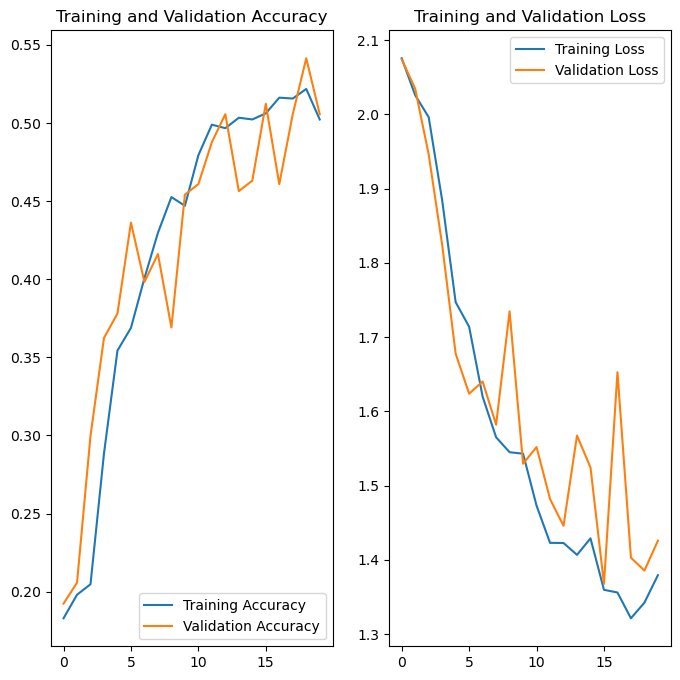

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

-Both the accuracies are quite improved comparing to presvious model which is good. But accuracy percentages are still low which needs to be improved.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [34]:
from pathlib import Path

## Your code goes here.

def create_class_distribution_dataframe(data_dir, class_names):
    """
    Create a DataFrame representing the distribution of classes in the dataset.

    Args:
        data_dir (str): Path to the dataset directory.
        class_names (list): List of class names.

    Returns:
        pd.DataFrame: DataFrame containing class names and their respective counts.
    """
    class_distribution_df = pd.DataFrame()

    for class_name in class_names:
        class_path = Path(data_dir) / class_name
        number_of_images = len(list(class_path.glob('*.jpg')))
        class_distribution_df = pd.concat([class_distribution_df, pd.DataFrame({'Class': [class_name], 'Number of Images': [number_of_images]})], ignore_index=True)

    class_distribution_df.sort_values(by='Number of Images', inplace=True)
    return class_distribution_df

# Create the class distribution DataFrame
class_distribution_df = create_class_distribution_dataframe(data_dir_train, class_names)
class_distribution_df


,Class,Number of Images
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


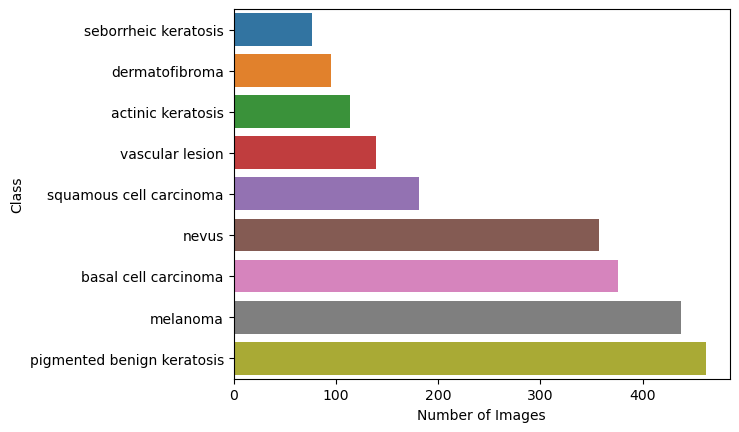

In [35]:
import seaborn as sns
sns.barplot(x=class_distribution_df['Number of Images'],y=class_distribution_df['Class'],orient='h')
#plt.xticks(rotation=90)
#plt.tight_layout()
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

-seborrheic keratosis with 77 images

#### - Which classes dominate the data in terms proportionate number of samples?

-pigmented benign keratosis with 462 images


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
#!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [30]:
import Augmentor

In [37]:
import pathlib
import Augmentor

path_to_training_dataset = pathlib.Path(r'D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train')

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)
 ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D4D516AFD0>: 100%|█| 500/500 [00:13<00:00, 37.51 Samples/


Initialised with 376 image(s) found.
Output directory set to D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D4D5198D50>: 100%|█| 500/500 [00:13<00:


Initialised with 95 image(s) found.
Output directory set to D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D4D4FCCFD0>: 100%|█| 500/500 [00:13<00:00, 36.39 Samples/


Initialised with 438 image(s) found.
Output directory set to D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1D485909D10>: 100%|█| 500/500 [01:08<00:00,  7.32 Sample


Initialised with 357 image(s) found.
Output directory set to D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x1D4D4EFBC50>: 100%|█| 500/500 [01:03<00:00,  7.89 Sample


Initialised with 462 image(s) found.
Output directory set to D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D4D4FE9750>: 100%|█| 500/500 [00:13<00:00, 36.22 Samples/


Initialised with 77 image(s) found.
Output directory set to D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1D4D4ECCB10>: 100%|█| 500/500 [00:31<00


Initialised with 181 image(s) found.
Output directory set to D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D4D4F32410>: 100%|█| 500/500 [00:13<00:00, 36.31 Samples/


Initialised with 139 image(s) found.
Output directory set to D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D4D51BF9D0>: 100%|█| 500/500 [00:13<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['D:\\IIITB\\Deep Learning\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_46b496cf-9cba-4273-901b-ad9ade348566.jpg',
 'D:\\IIITB\\Deep Learning\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b4af3b16-73ed-4b34-b3f9-da9d9e3b524b.jpg',
 'D:\\IIITB\\Deep Learning\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1353f3a1-deb1-4903-b685-bb2d47169de5.jpg',
 'D:\\IIITB\\Deep Learning\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_47e89312-0f8a-4b06-ba9a-1e5234af4da5.jpg',
 'D:\\IIITB\\Deep Learning\\CNN\\CNN_assignment\\Skin cancer ISIC Th

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [41]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [42]:
import pandas as pd
import pathlib

# Assuming original_df is a WindowsPath object
original_df = pathlib.Path(r'D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train')

# Creating a new DataFrame (df2)
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

# Creating a DataFrame from original_df (assuming it contains file paths)
original_df = pd.DataFrame({'Path': [str(file) for file in original_df.iterdir()]})

# Appending df2 to original_df
new_df = original_df.append(df2, ignore_index=True)


C:\Users\balud\AppData\Local\Temp\ipykernel_10324\3165265865.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2, ignore_index=True)


In [43]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [45]:
data_dir_train=pathlib.Path(r'D:\IIITB\Deep Learning\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
## your code goes here
model = Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# first layer
model.add(Conv2D(32, kernel_size=(3,3),padding="same",activation='relu',input_shape=(180, 180, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
# second layer
model.add(Conv2D(64, kernel_size=(3, 3),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# third layer
model.add(Conv2D(128, kernel_size=(3, 3),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# fourth layer
model.add(Conv2D(128, kernel_size=(5, 5),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# fifth layer
model.add(Conv2D(256, kernel_size=(7, 7),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# sixth layer
model.add(Conv2D(256, kernel_size=(3, 3),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
# softmax layer
model.add(Dense(9,activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## your code goes here
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])


In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 128)      

#### **Todo:**  Train your model

In [50]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(train_ds, batch_size=32 ,epochs=epochs, verbose=1, validation_data=validation_ds)

Epoch 1/50
169/169 [==============================] - 349s 2s/step - loss: 2.1494 - accuracy: 0.1537 - val_loss: 2.0139 - val_accuracy: 0.2438
Epoch 2/50
169/169 [==============================] - 349s 2s/step - loss: 1.9924 - accuracy: 0.2188 - val_loss: 1.9354 - val_accuracy: 0.2260
Epoch 3/50
169/169 [==============================] - 338s 2s/step - loss: 1.8692 - accuracy: 0.2721 - val_loss: 1.7020 - val_accuracy: 0.4340
Epoch 4/50
169/169 [==============================] - 347s 2s/step - loss: 1.7027 - accuracy: 0.3431 - val_loss: 1.4865 - val_accuracy: 0.4899
Epoch 5/50
169/169 [==============================] - 363s 2s/step - loss: 1.5789 - accuracy: 0.3737 - val_loss: 1.4758 - val_accuracy: 0.4989
Epoch 6/50
169/169 [==============================] - 368s 2s/step - loss: 1.5095 - accuracy: 0.4015 - val_loss: 1.4051 - val_accuracy: 0.4899
Epoch 7/50
169/169 [==============================] - 345s 2s/step - loss: 1.4481 - accuracy: 0.4232 - val_loss: 1.3330 - val_accuracy: 0.5101

#### **Todo:**  Visualize the model results

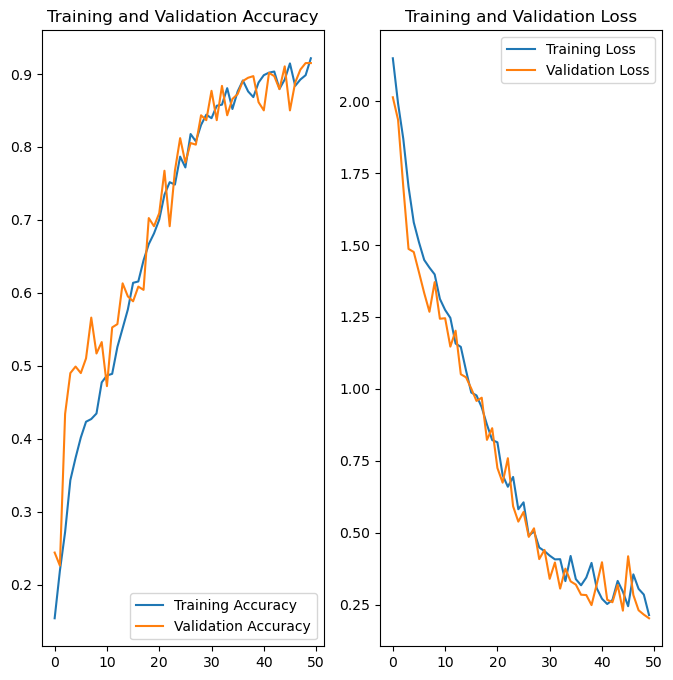

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Both the accuracies are very much close.
- Loss also seems pretty close and similar jump can be seen between epochs 30-40
- Validation accuracy is 91% which is good fit.

## Testing the Model:

1/1 [==============================] - 5s 5s/step
Actual Class: vascular lesion
Predictive Class: vascular lesion


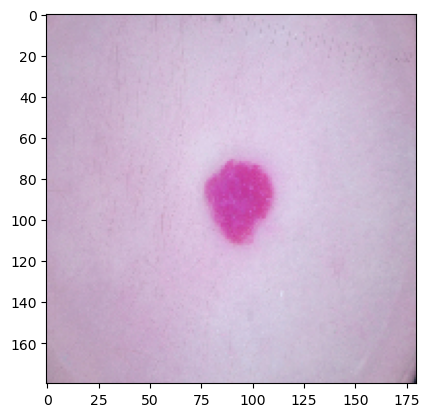

In [53]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[8], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[8]}" + '\n' + "Predictive Class: " + pred_class)